# Collect arcs

##### deepmoji

In [1]:
import json

traces_emojjy = {}
univerces = None
name_mappings_emojjy = {}

with open('data/tvmaze.arcs.tsv', encoding='utf-8') as ifh:
    for i, line in enumerate(ifh):
        chunks = line.strip().split('\t')
        name = chunks[1] + '_' + chunks[0]
        name_mappings_emojjy[i] = name
        univerces = json.loads(chunks[2])
        traces_emojjy[i] = univerces

##### Genre classifier

In [5]:
import pickle
import copy 


with open('data/best_traces_5.pkl', 'rb') as f:
    data = pickle.load(f)

In [6]:
with open('name_mappings.pkl', 'rb') as f:
    name_mappings = pickle.load(f)

In [7]:
inv_mapping = {name_mappings[i].split('/')[0].strip(): i for i in name_mappings.keys()}

In [8]:
traces_both = copy.deepcopy(traces_emojjy)

traces_tags = {k: {} for k in traces_emojjy.keys()}

for k, v in data.items():
    name = k.split('_')[1] + ' ' + k.split('_')[2]
    if name in inv_mapping.keys():
        traces_both[inv_mapping[name]].update(v)
        traces_tags[inv_mapping[name]] = v

### Collect tags meta-information

In [9]:
import re
import tqdm
import pandas as pd

movie_meta = {k: v.split('/') for k,v in name_mappings.items()}

movie_tags = {k: re.sub("[\[\]\"\ ]", '', v[2].split('_')[0].strip()).split(',') for k, v in movie_meta.items()}

all_tags = []

for t in movie_tags.values():
    all_tags += t
    
all_tags = list(set(all_tags))

all_tags.remove('')
all_tags.remove('s1')

all_data = pd.DataFrame(columns=(['key', 'cluster']+all_tags))

all_data['key'] = list(movie_tags.keys())
#all_data['cluster'] = clust

for k, v in tqdm.tqdm(movie_tags.items()):
    try:
        for t in v:
            all_data[t].iloc[k] = 1
    except:
        pass

  0%|          | 0/21962 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
100%|██████████| 21962/21962 [00:05<00:00, 4068.84it/s]


In [10]:
tags_frequencies = {k: all_data[k].sum() for k in all_tags}
tags_mapping = {k: i for i, k in enumerate(all_tags)}

In [11]:
all_data['frequent'] = None

for k, v in movie_tags.items():
    curr_max = 0
    for t in v:
        try:
            if tags_frequencies[t] >= curr_max:
                curr_max = tags_frequencies[t]
                all_data['frequent'].iloc[k] = tags_mapping[t]
        except Exception as e:
            pass

## Collect features

In [12]:
def get_area_below(trace):
    return np.trapz(trace, dx=0.01)/len(trace)

def get_intersection_stats(first, second):
    loveUp = 0
    sadUp = 0
    for i, (l, s) in enumerate(zip(first, second)):
        if i==0:
            if l<=s:
                flag = 1
            else:
                flag = -1
        else:
            if l<=s and flag==-1:
                sadUp += 1
                flag = 1
            if l>s and flag==1:
                loveUp += 1
                flag = -1
    return loveUp, sadUp

In [13]:
def get_stats(trace):
    return np.min(trace), np.max(trace), np.mean(trace), np.median(trace), np.var(trace)

In [14]:
import numpy as np

def get_feats(traces, feats_list=['AREA']):
    
    cols = ['key']
    unique_keys = []

    for k in traces.keys():
        unique_keys += list(traces[k].keys())
    unique_keys = set(unique_keys)

    if 'AREA' in feats_list:
        for k in unique_keys:
            cols += ['Area_{0}'.format(k)]
    
    if 'UpDown' in feats_list:
        feels_pairs = list(itertools.combinations(set(unique_keys), 2))
        
        for l, r in feels_pairs:
            cols += ['{0}Up{1}'.format(l,r), '{0}Up{1}'.format(r,l)]
    if 'Stats' in feats_list:
        for k in unique_keys:
            cols += ['Min_{0}'.format(k),'Max_{0}'.format(k),'Mean_{0}'.format(k),'Median_{0}'.format(k), 'Var_{0}'.format(k)]


    arc_feats = pd.DataFrame(columns=cols)

    for k in tqdm.tqdm(traces.keys()):
        curr_feats = {ks: 0 for ks in arc_feats.keys()}
        curr_feats['key'] = k
        
        if 'Stats' in feats_list:
            for single in traces[k].keys():
                curr_feats['Min_{0}'.format(single)],\
                curr_feats['Max_{0}'.format(single)], \
                curr_feats['Mean_{0}'.format(single)],\
                curr_feats['Median_{0}'.format(single)],\
                curr_feats['Var_{0}'.format(single)] = get_stats(np.array(traces[k][single]))

        if 'AREA' in feats_list:
            for single in traces[k].keys():
                curr_feats['Area_{0}'.format(single)] = get_area_below(np.array(traces[k][single]))
        if 'UpDown' in feats_list:
            for (l, r) in list(itertools.combinations(traces[k].keys(), 2)):
                curr_feats['{0}Up{1}'.format(l,r)], curr_feats['{0}Up{1}'.format(r,l)] = get_intersection_stats(traces[k][l], traces[k][r])

        arc_feats = arc_feats.append(curr_feats, ignore_index=True)
    return arc_feats

### Clustering, parameter tuning

In [15]:
import itertools

feats = [['AREA'], ['Stats'], ['UpDown'], ['AREA', 'Stats'], ['Stats', 'UpDown'], ['AREA', 'UpDown'], ['AREA', 'Stats', 'UpDown']]

n_components = [200]

n_clusters = [200]

combs = list(itertools.product(n_components, n_clusters))

In [16]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

for traces in [traces_emojjy, traces_tags, traces_both]:
    for f in feats:
        curr_feats = get_feats(traces, f).drop(['key'], axis=1).fillna(0).values
        max_err = 0
        best_comb = None
        for c in tqdm.tqdm(combs):
            #clean_data = VarianceThreshold(threshold=0.000001).fit_transform(curr_feats)
            
            compressed_data = PCA(n_components=min(curr_feats.shape[1], c[0])).fit_transform(curr_feats)

            clust = KMeans(n_clusters=c[1]).fit_predict(compressed_data)
            
            all_data['cluster'] = clust
            
            
            err = mutual_info_score(all_data[all_data['frequent'].fillna(0)!=0]['cluster'], all_data[all_data['frequent'].fillna(0)!=0]['frequent'].fillna(0))
            print('FEATS: {0}, n_components: {1}, n_clust: {2}, mutual info: {3}'.format(f, c[0], c[1], err))
            if err>max_err:
                max_err = err
                best_comp = [c[0], c[1], err]
        print('For feat {0}, best combo - components {1}, clust {2} with error {3}'.format(f, c[0], c[1], err))



  0%|          | 0/1 [00:25<?, ?it/s]


KeyboardInterrupt: 

### Use best parameters

In [17]:
SMOOTH = 1e-3 # 0.0
ALPHA = 0.99  # 1.0
ARC_TH = 0.1 
ARC_PEAK_TH = 0.3
INTERP = 20

def print_trace(tale_idx, curr_traces, path):
    for name, row in curr_traces.items():
        row = np.interp(np.linspace(0, 1., INTERP), list(map(lambda x:x/len(row),range(len(row)))), row)
        plt.plot(np.linspace(0, 1., INTERP), row, label=name)
    plt.suptitle(f"{tale_idx} {name_mappings[tale_idx]}")
    plt.legend()
    plt.savefig(path)
    plt.clf()

In [20]:
from sklearn.metrics import silhouette_score
arc_feats_1 = get_feats(traces_tags, ['Area', 'Stats'])
curr_feats = arc_feats_1.drop(['key'], axis=1).fillna(0).values

clean_data = VarianceThreshold(threshold=0.000001).fit_transform(curr_feats)

compressed_data = PCA(n_components=min(clean_data.shape[1], 200)).fit_transform(clean_data)

clust = KMeans(n_clusters=200).fit_predict(compressed_data)

err =silhouette_score(compressed_data, clust)
print('genres only: ', err)

arc_feats = get_feats(traces_emojjy, ['Area', 'Stats'])
curr_feats = arc_feats.drop(['key'], axis=1).fillna(0).values

clean_data = VarianceThreshold(threshold=0.000001).fit_transform(curr_feats)

compressed_data = PCA(n_components=min(clean_data.shape[1], 200)).fit_transform(clean_data)

clust = KMeans(n_clusters=200).fit_predict(compressed_data)

err =silhouette_score(compressed_data, clust)
print('emojy only: ', err)

  0%|          | 48/21962 [00:00<00:46, 470.60it/s]

genres only:  0.23822457652924317


100%|██████████| 21962/21962 [00:59<00:00, 370.47it/s]


emojy only:  0.1698450983518356


In [127]:
import os
import tqdm
import matplotlib.pyplot as plt

os.makedirs('cluster_results_movie')

arc_feats = get_feats(traces_both, ['AREA', 'Stats'])

curr_feats = arc_feats.drop(['key'], axis=1).fillna(0).values

for cluster in list(set(clust)):
    os.makedirs('cluster_results_movie/{0}'.format(cluster))
    
for i in tqdm.tqdm(range(len(clust))):
    key = arc_feats['key'].iloc[i]
    value = clust[i]
    try:
        print_trace(key, traces_both[key], 'cluster_results_movie/{0}/{1}.png'.format(value, key))
    except Exception as e:
        print('Error on: ', key)
        print(e)

 36%|███▌      | 7803/21962 [33:20<47:29,  4.97it/s]  

Error on:  7802.0

7802.0 Broke A$$ Game Show s2 / Game Show / ["Comedy"]_5566s2
              ^
Expected end of text, found '$'  (at char 14), (line:1, col:15)


100%|██████████| 21962/21962 [1:43:52<00:00,  3.52it/s]


<Figure size 432x288 with 0 Axes>

In [128]:
import pickle

with open('cl_stable.pkl', 'wb') as f:
    pickle.dump(clust, f)
    
len(clust), len(traces_both)

(21962, 21962)

## Interprete results - find clusters, corresponding to tags

In [98]:
err = mutual_info_score(clust, all_data['frequent'].fillna(0))


In [78]:
arc_feats.head()

key  Area_Fantasy  Area_Family  Area_FORCE  Area_HAPPY  Area_FEAR  \
0  0.0           0.0          0.0         0.0         0.0        0.0   
1  1.0           0.0          0.0         0.0         0.0        0.0   
2  2.0           0.0          0.0         0.0         0.0        0.0   
3  3.0           0.0          0.0         0.0         0.0        0.0   
4  4.0           0.0          0.0         0.0         0.0        0.0   

   Area_LOVE  Area_Crime  Area_Sci-Fi  Area_DEAL  ...  Mean_Comedy  \
0    0.00000         0.0          0.0        0.0  ...     0.000000   
1    0.00067         0.0          0.0        0.0  ...     0.100421   
2    0.00000         0.0          0.0        0.0  ...     0.068469   
3    0.00000         0.0          0.0        0.0  ...     0.000000   
4    0.00000         0.0          0.0        0.0  ...     0.246853   

   Median_Comedy  Var_Comedy  Min_Animation  Max_Animation  Mean_Animation  \
0       0.000000    0.000000            0.0            0.0             0.0   
1       0.012812    0.014827            0.0            0.0             0.0   
2       0.025522    0.012121            0.0            0.0             0.0   
3       0.000000    0.000000            0.0            0.0             0.0   
4       0.224558    0.030552            0.0            0.0             0.0   

   Median_Animation  Var_Animation  cluster  genre_pred  
0               0.0            0.0       69          31  
1               0.0            0.0      153          31  
2               0.0            0.0       57          31  
3               0.0            0.0      183          31  
4               0.0            0.0       84          31  

[5 rows x 189 columns]

In [93]:
arc_feats['genre'] = all_data['frequent'].fillna(0)
all_data['frequent']

0          31
1          31
2           6
3          31
4          31
         ... 
21957      33
21958    None
21959    None
21960      33
21961       8
Name: frequent, Length: 21962, dtype: object

In [113]:
clust_table = pd.DataFrame(columns=['cluster', 'size', 'dominant tag', 'dominant tag %'])

#clust_table['cluster'] = clust

for c in tqdm.tqdm(list(set(clust))):
    tmp = {}
    sub = arc_feats[arc_feats['cluster']==c]
    tmp['cluster'] = c
    tmp['size'] = len(sub)
    tags_freq = 0
    for t, s in sub.groupby('genre'):
        if len(s)>tags_freq:
            tags_freq = len(s)
            most_freq = t
    tmp['dominant tag'] = tags_inv_mapping[most_freq]
    tmp['dominant tag %'] = len(sub[sub['genre']==most_freq])/len(sub)
    if tmp['dominant tag %'] <= 0.6:
        tags_freq = 0
        most_freq_prev = most_freq
        for t, s in sub.groupby('genre'):
            if t != most_freq_prev:
                if len(s)>tags_freq:
                    tags_freq = len(s)
                    most_freq = t
        tmp['dominant tag'] += ', ' + tags_inv_mapping[most_freq]
        tmp['dominant tag %'] += len(sub[sub['genre']==most_freq])/len(sub)
    clust_table = clust_table.append(tmp, ignore_index=True)

100%|██████████| 200/200 [00:01<00:00, 127.35it/s]


In [114]:
clust_table.to_excel('cluster_info.xlsx')
clust_table

cluster size      dominant tag  dominant tag %
0         0  111   Comedy, Fantasy        0.486486
1         1   39             Drama        0.717949
2         2   80    Fantasy, Music        0.637500
3         3   82    Fantasy, Drama        0.670732
4         4  108           Fantasy        0.648148
..      ...  ...               ...             ...
195     195  112    Drama, Fantasy        0.660714
196     196   41  History, Fantasy        0.536585
197     197   50    Fantasy, Drama        0.740000
198     198   46             Music        0.608696
199     199  204   Comedy, Fantasy        0.754902

[200 rows x 4 columns]

In [85]:
tags_inv_mapping = {tags_mapping[k]: k for k in tags_mapping.keys()}
tags_inv_mapping

{0: 'Fantasy',
 1: 'Family',
 2: 'Medical',
 3: 'News',
 4: 'Science-Fiction',
 5: 'Legal',
 6: 'Crime',
 7: 'Action',
 8: 'Music',
 9: 'Reality',
 10: 'Travel',
 11: 'War',
 12: 'Nature',
 13: 'Espionage',
 14: 'Sports',
 15: 'Food',
 16: 'Adult',
 17: '10Challenges1',
 18: 'Thriller',
 19: 'Romance',
 20: 'DIY',
 21: 'Documentary',
 22: 'Children',
 23: 'Mystery',
 24: 'Adventure',
 25: 'Western',
 26: 'GameShow',
 27: 'Variety',
 28: 'History',
 29: 'Anime',
 30: 'TalkShow',
 31: 'Drama',
 32: 'Horror',
 33: 'Comedy',
 34: 'Supernatural',
 35: 'Scripted',
 36: 'Animation'}

In [22]:
# restore labels

cl_genre_mapping = {}

for cl in tqdm.tqdm(list(set(clust))):
    curr_clust_idx = []
    for tmp_idx, tmp_val in enumerate(clust):
        if tmp_val==cl:
            curr_clust_idx.append(tmp_idx)
    inters = 0
    best_guess = None
    for genre in list(set(all_data['frequent'].fillna(0).values)):
        if genre!=0:
            curr_genre_idx = []
            for tmp_idx, tmp_val in enumerate(all_data['frequent'].fillna(0).values):
                if tmp_val==genre:
                    curr_genre_idx.append(tmp_idx)
            inters_curr = len(set(curr_clust_idx).intersection(curr_genre_idx))
            if inters_curr >= inters:
                inters = inters_curr
                best_guess = genre
    cl_genre_mapping[cl] = best_guess

100%|██████████| 200/200 [01:22<00:00,  2.42it/s]


In [115]:
all_data['cluster'] = clust

In [23]:
arc_feats['cluster'] = clust
arc_feats['genre_pred'] = [cl_genre_mapping[c] for c in arc_feats['cluster']]

In [129]:
arc_feats['Area_FEAR'].mean()

0.00045281916646529465

In [65]:
feats_only = arc_feats[list(set(arc_feats.columns)-set(['key', 'cluster', 'genre_pred']))]

In [66]:
feats_only_norm = (feats_only - feats_only.mean()) / (feats_only.max() - feats_only.min())
feats_only_norm

Max_EYES  Area_Sci-Fi  Var_WINK  Area_Western  Median_Family  \
0     -0.001983    -0.005996 -0.013333     -0.000417      -0.007634   
1     -0.001983    -0.005996  0.046834     -0.000417      -0.007634   
2     -0.001983    -0.005996 -0.013333     -0.000417      -0.007634   
3     -0.001983    -0.005996 -0.013333     -0.000417      -0.007634   
4     -0.001983    -0.005996  0.100380     -0.000417      -0.007634   
...         ...          ...       ...           ...            ...   
21957 -0.001983    -0.005996 -0.013333     -0.000417      -0.007634   
21958 -0.001983    -0.005996 -0.013333     -0.000417      -0.007634   
21959 -0.001983    -0.005996 -0.013333     -0.000417      -0.007634   
21960 -0.001983    -0.005996 -0.013333     -0.000417      -0.007634   
21961 -0.001983    -0.005996 -0.013333     -0.000417      -0.007634   

       Max_Family  Max_Romance  Mean_Musical  Max_FEAR  Max_Drama  ...  \
0       -0.006857    -0.004074      -0.00413 -0.072833   0.531737  ...   
1       -0.006857    -0.004074      -0.00413 -0.072833   0.541336  ...   
2       -0.006857    -0.004074      -0.00413 -0.072833   0.539948  ...   
3       -0.006857    -0.004074      -0.00413 -0.072833   0.551209  ...   
4       -0.006857    -0.004074      -0.00413 -0.072833  -0.145921  ...   
...           ...          ...           ...       ...        ...  ...   
21957   -0.006857    -0.004074      -0.00413 -0.072833  -0.038841  ...   
21958   -0.006857    -0.004074      -0.00413 -0.072833  -0.123122  ...   
21959   -0.006857    -0.004074      -0.00413 -0.072833   0.551405  ...   
21960   -0.006857    -0.004074      -0.00413 -0.072833   0.231785  ...   
21961   -0.006857    -0.004074      -0.00413 -0.072833  -0.448452  ...   

       Area_Drama  Max_Musical  Area_FEAR  Max_LOVE  Min_Thriller  Max_FORCE  \
0        0.530049    -0.004474  -0.056953 -0.157943      -0.02025  -0.035010   
1        0.469821    -0.004474  -0.056953  0.146910      -0.02025  -0.035010   
2        0.577567    -0.004474  -0.056953 -0.157943      -0.02025  -0.035010   
3        0.468452    -0.004474  -0.056953 -0.157943      -0.02025  -0.035010   
4       -0.171063    -0.004474  -0.056953 -0.157943      -0.02025  -0.035010   
...           ...          ...        ...       ...           ...        ...   
21957   -0.096908    -0.004474  -0.056953  0.202071      -0.02025  -0.035010   
21958   -0.133637    -0.004474  -0.056953 -0.157943      -0.02025  -0.035010   
21959    0.535928    -0.004474  -0.056953 -0.157943      -0.02025  -0.035010   
21960   -0.253014    -0.004474  -0.056953 -0.050282      -0.02025  -0.035010   
21961   -0.253014    -0.004474  -0.056953 -0.000019      -0.02025   0.132242   

       Min_Mystery  Min_MISC  Area_Adventure  Area_Fantasy  
0        -0.001184 -0.001901       -0.007029     -0.000337  
1        -0.001184 -0.001901       -0.007029     -0.000337  
2        -0.001184 -0.001901       -0.007029     -0.000337  
3        -0.001184 -0.001901       -0.007029     -0.000337  
4        -0.001184 -0.001901       -0.007029     -0.000337  
...            ...       ...             ...           ...  
21957    -0.001184 -0.001901       -0.007029     -0.000337  
21958    -0.001184 -0.001901        0.559219     -0.000337  
21959    -0.001184 -0.001901       -0.007029     -0.000337  
21960    -0.001184 -0.001901       -0.007029     -0.000337  
21961    -0.001184 -0.001901       -0.007029     -0.000337  

[21962 rows x 186 columns]

In [68]:
import warnings
warnings.filterwarnings('ignore')

to_analyze = pd.DataFrame(columns=(['genre', 'clust'] + ['Mean_{}'.format(i) for i in feats_only_norm.columns]))
total = {'genre': 'total', 'clust': 'total'}
total.update({'Mean_{}'.format(t): feats_only_norm[t].astype(float).mean() for t in feats_only_norm.columns})
to_analyze = to_analyze.append(total, ignore_index=True)
tags_inv = {tags_mapping[i]: i for i in tags_mapping.keys()}

for g in tqdm.tqdm(list(set(arc_feats['genre_pred'].values))):
    print("========================================== GENRE: ", tags_inv[g])
    for c in list(set(arc_feats['cluster'].values)):
        tmp = {'genre': tags_inv[g], 'clust': c}
        sub_df = feats_only_norm[arc_feats['cluster']==c][arc_feats['genre_pred']==g]
        if len(sub_df)<100 and len(sub_df)>5:
            tmp.update({'Mean_{}'.format(t): (total['Mean_{}'.format(t)] - sub_df[t].astype(float).mean()) for t in sub_df.columns})
            inv_tmp = {tmp[t]: t for t in list(set(tmp.keys())-set(['genre', 'clust']))}
            most_diffs_5 = sorted(list(inv_tmp.keys()))[:5]
            print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER: ", c, len(sub_df))

            print("MOST DIFFERENCE: ", {inv_tmp[k]: k for k in most_diffs_5})
            to_analyze = to_analyze.append(tmp, ignore_index=True)


  0%|          | 0/10 [00:00<?, ?it/s]

========================================== GENRE:  Comedy
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  3 82
MOST DIFFERENCE:  {'Mean_Max_LOVE': -0.3374984190985674, 'Mean_Mean_LOVE': -0.26458943821291747, 'Mean_Area_LOVE': -0.2621423711036977, 'Mean_Median_LOVE': -0.2606249001233287, 'Mean_Max_Comedy': -0.22779119351165728}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  13 95
MOST DIFFERENCE:  {'Mean_Max_SAD': -0.5904065916425454, 'Mean_Median_Comedy': -0.5122860517054216, 'Mean_Max_Comedy': -0.48654000454016494, 'Mean_Area_Comedy': -0.44639180594352335, 'Mean_Mean_Comedy': -0.4136150657155225}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  45 93
MOST DIFFERENCE:  {'Mean_Max_LOVE': -0.49307881929176944, 'Mean_Median_LOVE': -0.45513699642426864, 'Mean_Mean_LOVE': -0.43752483270427817, 'Mean_Area_LOVE': -0.4340576725550392, 'Mean_Min_LOVE': -0.3258011015547603}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  67 73
MOST DIFFERENCE: 

 10%|█         | 1/10 [00:01<00:15,  1.78s/it]

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  179 30
MOST DIFFERENCE:  {'Mean_Max_Music': -0.7035426103441711, 'Mean_Median_Music': -0.4196035657422817, 'Mean_Mean_Music': -0.40155849996877824, 'Mean_Area_Music': -0.33570357966767667, 'Mean_Var_Music': -0.3267544920962907}
========================================== GENRE:  Animation
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  154 11
MOST DIFFERENCE:  {'Mean_Median_Sport': -0.9645976227441526, 'Mean_Mean_Sport': -0.9510437945926534, 'Mean_Max_Sport': -0.9434949671657813, 'Mean_Area_Sport': -0.8794666124238606, 'Mean_Min_Sport': -0.803098692752372}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  163 9
MOST DIFFERENCE:  {'Mean_Max_Music': -0.8619172363249129, 'Mean_Median_Music': -0.6660935544517099, 'Mean_Max_WINK': -0.6559405719574921, 'Mean_Mean_Music': -0.6274521719484589, 'Mean_Mean_WINK': -0.6021051470125424}


 20%|██        | 2/10 [00:02<00:11,  1.41s/it]

========================================== GENRE:  Action
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  7 29
MOST DIFFERENCE:  {'Mean_Max_Sci-Fi': -0.5983525137536729, 'Mean_Max_MAD': -0.539912603116656, 'Mean_Median_MAD': -0.4368692264539531, 'Mean_Mean_MAD': -0.41007777223529646, 'Mean_Area_MAD': -0.4067128933025509}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  37 60
MOST DIFFERENCE:  {'Mean_Max_Action': -0.8609137598555155, 'Mean_Median_Action': -0.7035402592012113, 'Mean_Mean_Action': -0.6715150176214182, 'Mean_Area_Action': -0.6282581559918142, 'Mean_Max_MAD': -0.4264569528483291}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  46 63
MOST DIFFERENCE:  {'Mean_Max_Sci-Fi': -0.9348736596014758, 'Mean_Median_Sci-Fi': -0.7366545498763958, 'Mean_Mean_Sci-Fi': -0.6903124972640742, 'Mean_Area_Sci-Fi': -0.6608860972028535, 'Mean_Max_MAD': -0.5201417226000609}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  62 63
MOST DIFFERENCE:  {'M

 30%|███       | 3/10 [00:03<00:09,  1.39s/it]

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  194 16
MOST DIFFERENCE:  {'Mean_Max_Adventure': -0.8544461674779299, 'Mean_Mean_Adventure': -0.6472432493410794, 'Mean_Area_Adventure': -0.6175732925571757, 'Mean_Median_Adventure': -0.5975029584275959, 'Mean_Max_MAD': -0.5157690536553612}
========================================== GENRE:  Music
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  2 80
MOST DIFFERENCE:  {'Mean_Max_DEAL': -0.46038738370324933, 'Mean_Median_DEAL': -0.44689980263669127, 'Mean_Mean_DEAL': -0.41743810617997973, 'Mean_Area_DEAL': -0.4153267799502923, 'Mean_Min_DEAL': -0.375086280067374}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  17 73
MOST DIFFERENCE:  {'Mean_Max_Music': -0.9399397146338885, 'Mean_Median_Music': -0.7717734372090909, 'Mean_Mean_Music': -0.6430622227163116, 'Mean_Max_DEAL': -0.6197212338831968, 'Mean_Area_Music': -0.5988891117378476}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  47 98
MOST DIF

 40%|████      | 4/10 [00:05<00:08,  1.40s/it]

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  147 59
MOST DIFFERENCE:  {'Mean_Max_Music': -0.9206088513238245, 'Mean_Median_Music': -0.8818690140604215, 'Mean_Mean_Music': -0.8428301691061879, 'Mean_Min_Music': -0.6807751291868215, 'Mean_Area_Music': -0.6091129998386517}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  198 46
MOST DIFFERENCE:  {'Mean_Max_Music': -0.768255159047081, 'Mean_Median_Music': -0.7132340724726801, 'Mean_Mean_Music': -0.709534526978415, 'Mean_Min_Music': -0.6780465472461409, 'Mean_Mean_MUSIC': -0.358953444991056}
========================================== GENRE:  Nature
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  133 39
MOST DIFFERENCE:  {'Mean_Max_Animation': -0.5835918470207998, 'Mean_Mean_Animation': -0.45127625023038404, 'Mean_Median_Animation': -0.4427004489474385, 'Mean_Min_Animation': -0.35664912854329406, 'Mean_Area_Animation': -0.32786301588175}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  134

 50%|█████     | 5/10 [00:05<00:05,  1.18s/it]

========================================== GENRE:  Sports
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  23 90
MOST DIFFERENCE:  {'Mean_Max_Sport': -0.9279634673048456, 'Mean_Median_Sport': -0.8596495973668018, 'Mean_Max_DEAL': -0.7423109681655974, 'Mean_Mean_Sport': -0.7359105332488949, 'Mean_Area_Sport': -0.7003003946590787}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  91 58
MOST DIFFERENCE:  {'Mean_Max_Sport': -0.7610967113479631, 'Mean_Max_DEAL': -0.5536800981666231, 'Mean_Median_DEAL': -0.4751970928900526, 'Mean_Mean_DEAL': -0.44826054244209607, 'Mean_Area_DEAL': -0.4466556911645917}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  94 76
MOST DIFFERENCE:  {'Mean_Max_Sport': -0.7277283119542687, 'Mean_Max_DEAL': -0.5722475485738473, 'Mean_Median_DEAL': -0.4521586392663219, 'Mean_Mean_DEAL': -0.42525502154740685, 'Mean_Area_DEAL': -0.42356617636121763}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  130 44
MOST DIFFERENCE:  {'Me

 60%|██████    | 6/10 [00:06<00:04,  1.10s/it]

========================================== GENRE:  Food
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  6 78
MOST DIFFERENCE:  {'Mean_Max_HAPPY': -0.5907357095244027, 'Mean_Median_Comedy': -0.5582160769577117, 'Mean_Mean_Comedy': -0.5052142779442034, 'Mean_Max_Comedy': -0.48895164216734877, 'Mean_Mean_HAPPY': -0.45300199017428877}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  39 43
MOST DIFFERENCE:  {'Mean_Max_HAPPY': -0.5735603825425896, 'Mean_Mean_HAPPY': -0.4795508937255624, 'Mean_Area_HAPPY': -0.47448508473000756, 'Mean_Median_HAPPY': -0.46477969962974713, 'Mean_Min_HAPPY': -0.36380086687744784}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  191 86
MOST DIFFERENCE:  {'Mean_Median_Comedy': -0.5856599966696407, 'Mean_Mean_Comedy': -0.5375665962924693, 'Mean_Max_HAPPY': -0.5034353759870018, 'Mean_Area_Comedy': -0.5018282716547114, 'Mean_Max_Comedy': -0.49168194496991846}


 70%|███████   | 7/10 [00:07<00:03,  1.08s/it]

========================================== GENRE:  Children


 80%|████████  | 8/10 [00:08<00:01,  1.09it/s]

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  145 37
MOST DIFFERENCE:  {'Mean_Max_Animation': -0.8654134299588536, 'Mean_Mean_Animation': -0.6343488454366404, 'Mean_Median_Animation': -0.6289705128989711, 'Mean_Area_Animation': -0.5708250999447868, 'Mean_Max_LOVE': -0.47152266493522316}
========================================== GENRE:  History
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  58 42
MOST DIFFERENCE:  {'Mean_Max_Adventure': -0.5707957993467222, 'Mean_Mean_Adventure': -0.4119027675741329, 'Mean_Median_Adventure': -0.3644641961040473, 'Mean_Area_Adventure': -0.33786123512216815, 'Mean_Min_Adventure': -0.33036804907926154}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  72 98
MOST DIFFERENCE:  {'Mean_Max_DEAL': -0.6408479990699438, 'Mean_Median_Drama': -0.5670827198421933, 'Mean_Median_DEAL': -0.5304173702039434, 'Mean_Max_Drama': -0.5208153542669791, 'Mean_Mean_DEAL': -0.49442124288573563}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

 90%|█████████ | 9/10 [00:09<00:00,  1.06it/s]

========================================== GENRE:  Drama
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  1 39
MOST DIFFERENCE:  {'Mean_Max_MAD': -0.4943290744149567, 'Mean_Median_MAD': -0.4576822326000897, 'Mean_Mean_MAD': -0.4167403264647749, 'Mean_Area_MAD': -0.41361567303299096, 'Mean_Max_Thriller': -0.3961969310943179}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  10 54
MOST DIFFERENCE:  {'Mean_Max_Sport': -0.9299424014643863, 'Mean_Median_Sport': -0.9279967944138632, 'Mean_Mean_Sport': -0.9095285257809885, 'Mean_Min_Sport': -0.8109287598732692, 'Mean_Max_FORCE': -0.7939676144463249}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  14 73
MOST DIFFERENCE:  {'Mean_Max_Horror': -0.3126839364716984, 'Mean_Min_Thriller': -0.2947600727577497, 'Mean_Max_Thriller': -0.2618099577482257, 'Mean_Mean_Horror': -0.22752438787447274, 'Mean_Median_Horror': -0.2124113915513479}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  25 93
MOST DIFFERENCE

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  164 50
MOST DIFFERENCE:  {'Mean_Max_Sport': -0.9375996343773464, 'Mean_Max_FORCE': -0.8953028512644058, 'Mean_Median_Sport': -0.88927398669391, 'Mean_Median_FORCE': -0.8012203197860609, 'Mean_Mean_Sport': -0.7906202469564722}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  175 89
MOST DIFFERENCE:  {'Mean_Max_SAD': -0.6349228437447655, 'Mean_Max_Drama': -0.48625986233531987, 'Mean_Median_SAD': -0.4832061611985643, 'Mean_Mean_SAD': -0.45024067591429623, 'Mean_Area_SAD': -0.4485084342525635}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  178 33
MOST DIFFERENCE:  {'Mean_Max_Sport': -0.8417258398070342, 'Mean_Median_Sport': -0.6612311849148454, 'Mean_Mean_Sport': -0.5846822054792163, 'Mean_Max_LOVE': -0.5765607819521369, 'Mean_Area_Sport': -0.5083553364498202}
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CLUSTER:  182 50
MOST DIFFERENCE:  {'Mean_Max_DEAL': -0.640722568612845, 'Mean_Median_Drama': -

100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


In [69]:
to_analyze

genre  clust  Mean_Max_EYES  Mean_Area_Sci-Fi  Mean_Var_WINK  \
0    total  total   4.701336e-19     -4.852992e-19   2.709587e-17   
1   Comedy      3   1.983310e-03      5.996264e-03  -5.435440e-03   
2   Comedy     13  -1.232588e-03      5.508435e-03   8.068787e-03   
3   Comedy     45  -6.324104e-04      4.783805e-03   1.080361e-02   
4   Comedy     67  -1.859981e-03      4.438072e-03   3.898936e-03   
..     ...    ...            ...               ...            ...   
83   Drama    178   1.983310e-03      5.996264e-03   1.140880e-02   
84   Drama    182   1.983310e-03      5.996264e-03   1.049684e-02   
85   Drama    186   1.983310e-03     -3.402308e-03   6.017932e-03   
86   Drama    189   2.050114e-04     -1.383495e-02  -2.866780e-03   
87   Drama    197   1.983310e-03      5.996264e-03   2.558534e-03   

    Mean_Area_Western  Mean_Median_Family  Mean_Max_Family  Mean_Max_Romance  \
0        1.718768e-19       -4.610342e-18     1.455898e-18     -1.122254e-18   
1        4.167218e-04        7.633913e-03     6.857268e-03     -4.418520e-03   
2        4.167218e-04        7.633913e-03     6.857268e-03      4.074380e-03   
3        4.167218e-04       -1.011617e-01    -1.011110e-01      4.074380e-03   
4       -8.641604e-04        7.633913e-03     6.857268e-03      4.074380e-03   
..                ...                 ...              ...               ...   
83       4.167218e-04       -6.166460e-03    -1.250777e-02      4.074380e-03   
84       4.167218e-04        7.633913e-03     6.857268e-03      4.074380e-03   
85       4.167218e-04        7.633913e-03     6.857268e-03      4.074380e-03   
86      -9.492212e-03        7.633913e-03     6.857268e-03      4.074380e-03   
87      -1.502689e-05        7.633913e-03     6.857268e-03     -2.243660e-03   

    Mean_Mean_Musical  ...  Mean_Area_Drama  Mean_Max_Musical  Mean_Area_FEAR  \
0       -1.536781e-18  ...    -4.574754e-16     -1.617664e-19   -3.473125e-16   
1        4.130254e-03  ...    -1.256847e-02      4.474057e-03    4.455931e-02   
2        4.130254e-03  ...     1.009094e-01      4.474057e-03    4.957197e-02   
3        4.689432e-04  ...     2.348993e-01     -2.303285e-03    5.413506e-02   
4        4.130254e-03  ...    -2.872802e-01      4.474057e-03   -5.386622e-01   
..                ...  ...              ...               ...             ...   
83       4.130254e-03  ...     1.884995e-01      4.474057e-03    5.425693e-02   
84       4.130254e-03  ...    -4.804005e-01      4.474057e-03    3.972529e-02   
85       4.130254e-03  ...    -1.289315e-02      4.474057e-03    3.353831e-02   
86       4.130254e-03  ...    -1.660456e-01      4.474057e-03    1.378500e-02   
87       4.130254e-03  ...     1.724369e-01      4.474057e-03    4.537553e-02   

    Mean_Max_LOVE  Mean_Min_Thriller  Mean_Max_FORCE  Mean_Min_Mystery  \
0    4.270633e-16      -1.488251e-17    9.964810e-17      6.167344e-19   
1   -3.374984e-01       2.024968e-02    5.182303e-04      1.183922e-03   
2    1.019760e-01       2.024978e-02    3.500961e-02      1.183922e-03   
3   -4.930788e-01       2.024978e-02    2.381035e-02      1.183922e-03   
4    1.332440e-01       1.461996e-02    1.718184e-02      1.183922e-03   
..            ...                ...             ...               ...   
83  -5.765608e-01       2.024978e-02   -4.645211e-03      1.183922e-03   
84   5.207935e-02       2.020418e-02    1.289378e-02      1.183922e-03   
85  -5.024559e-01       2.024978e-02    2.887418e-02      1.183922e-03   
86   1.517249e-01       1.438336e-02    2.468328e-02      1.183922e-03   
87   7.327661e-02       2.024978e-02   -7.878938e-01      1.183922e-03   

    Mean_Min_MISC  Mean_Area_Adventure  Mean_Area_Fantasy  
0    1.329518e-18         2.588262e-18       1.870424e-19  
1    1.901337e-03         5.778434e-03       3.374911e-04  
2    1.901337e-03         7.029131e-03       3.374911e-04  
3    1.901337e-03        -2.081214e-04       3.374911e-04  
4   -1.596560e-03         5.658940e-03       3.374911

In [77]:
to_analyze.to_excel('analyze_plots.xlsx')

### Data visualisation

In [124]:
import seaborn as sns
import matplotlib.patheffects as PathEffects


def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", len(set(colors))))
    print(len(palette), len(set(colors)))
    # We create a scatter plot.
    f = plt.figure(figsize=(18, 18))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(len(set(colors))):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        #txt = ax.text(xtext, ytext, str(i), fontsize=10)
        txt = ax.text(xtext, ytext, str(map_tmp[i]), fontsize=30)

        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [20]:
from sklearn.manifold import TSNE

In [57]:
from sklearn.preprocessing import LabelEncoder

LabelEncoder().fit_transform(arc_feats['genre_pred'])

array([7, 7, 7, ..., 7, 7, 1])

In [118]:
arc_feats['genre_text'] = ''

map_tmp = {}

for cl, sub in arc_feats.groupby(by='cluster'):
    gen = sub['genre_pred'].iloc[0]
    if len(sub[sub['genre']==gen])/len(sub) >= 0.5:
        map_tmp[cl] = tags_inv_mapping[gen]
    else:
        map_tmp[cl] = ''

In [120]:
arc_feats['genre_text'] = arc_feats['cluster'].map(map_tmp)

  0%|          | 0/6 [00:00<?, ?it/s]

200 200


 17%|█▋        | 1/6 [05:34<27:54, 334.99s/it]

200 200


 33%|███▎      | 2/6 [11:05<22:14, 333.53s/it]

200 200


 50%|█████     | 3/6 [16:37<16:39, 333.12s/it]

200 200


 67%|██████▋   | 4/6 [22:02<11:01, 330.84s/it]

200 200


 83%|████████▎ | 5/6 [27:32<05:30, 330.60s/it]

200 200


100%|██████████| 6/6 [33:02<00:00, 330.49s/it]


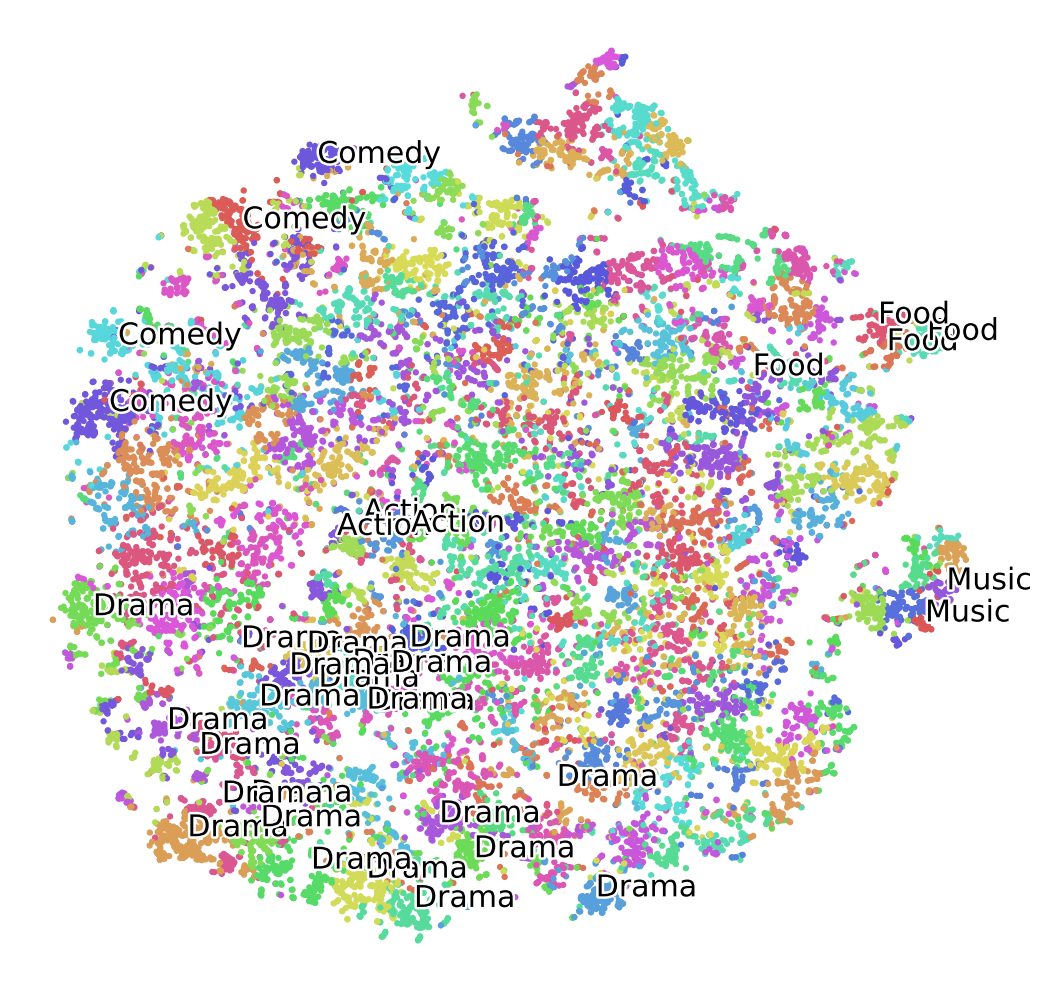

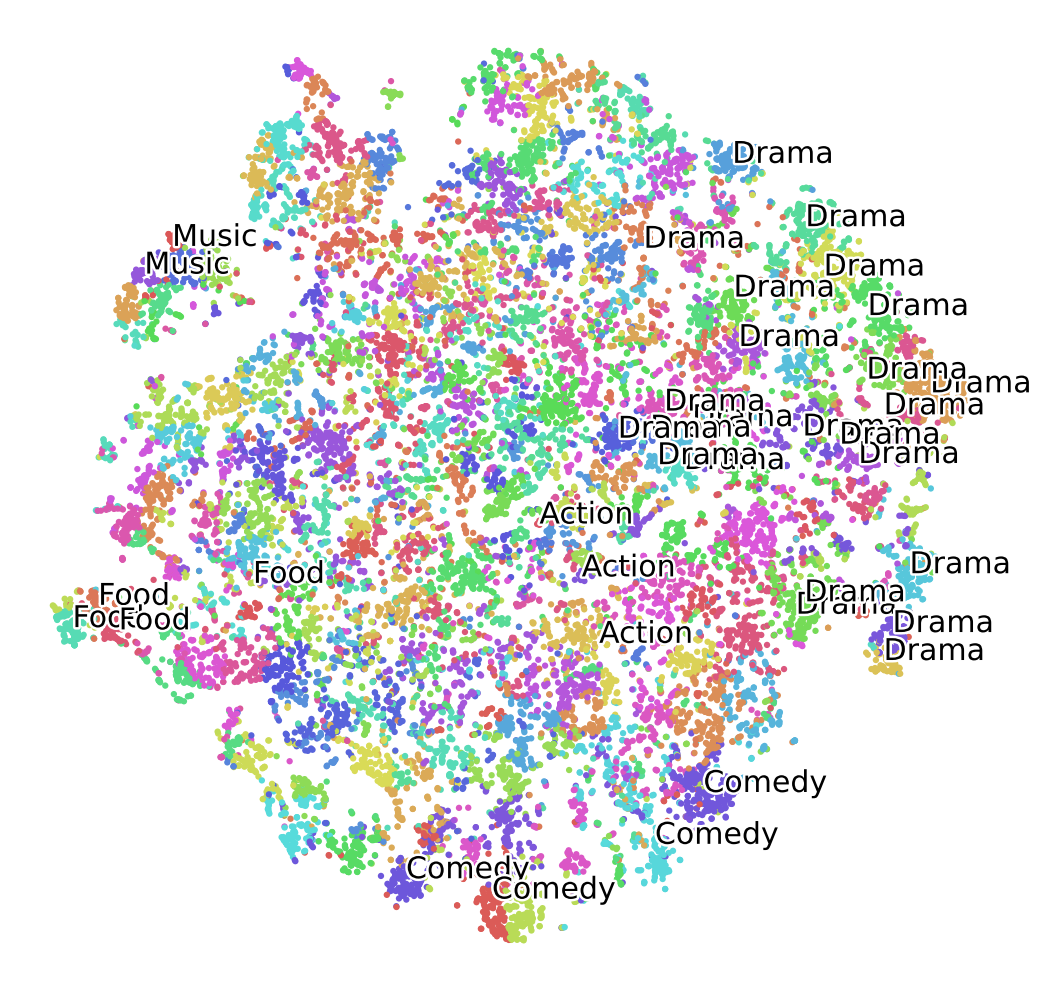

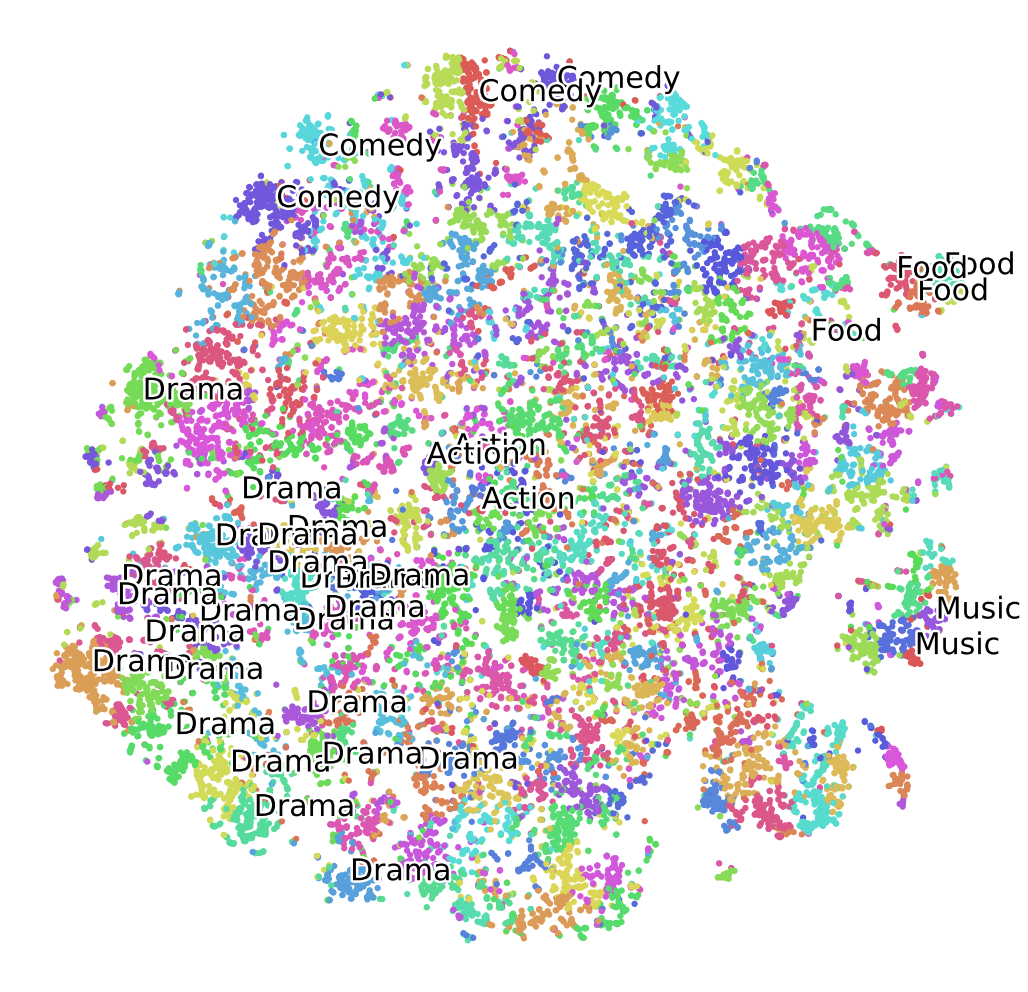

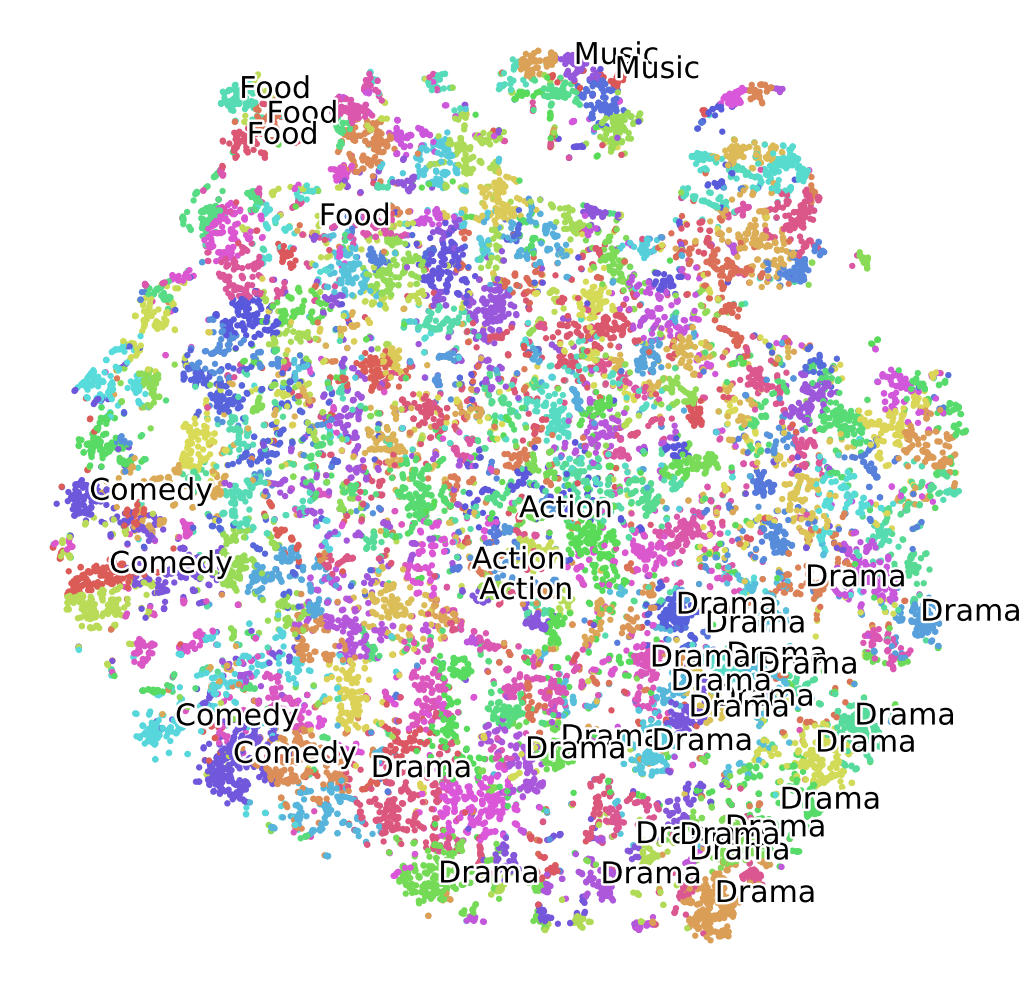

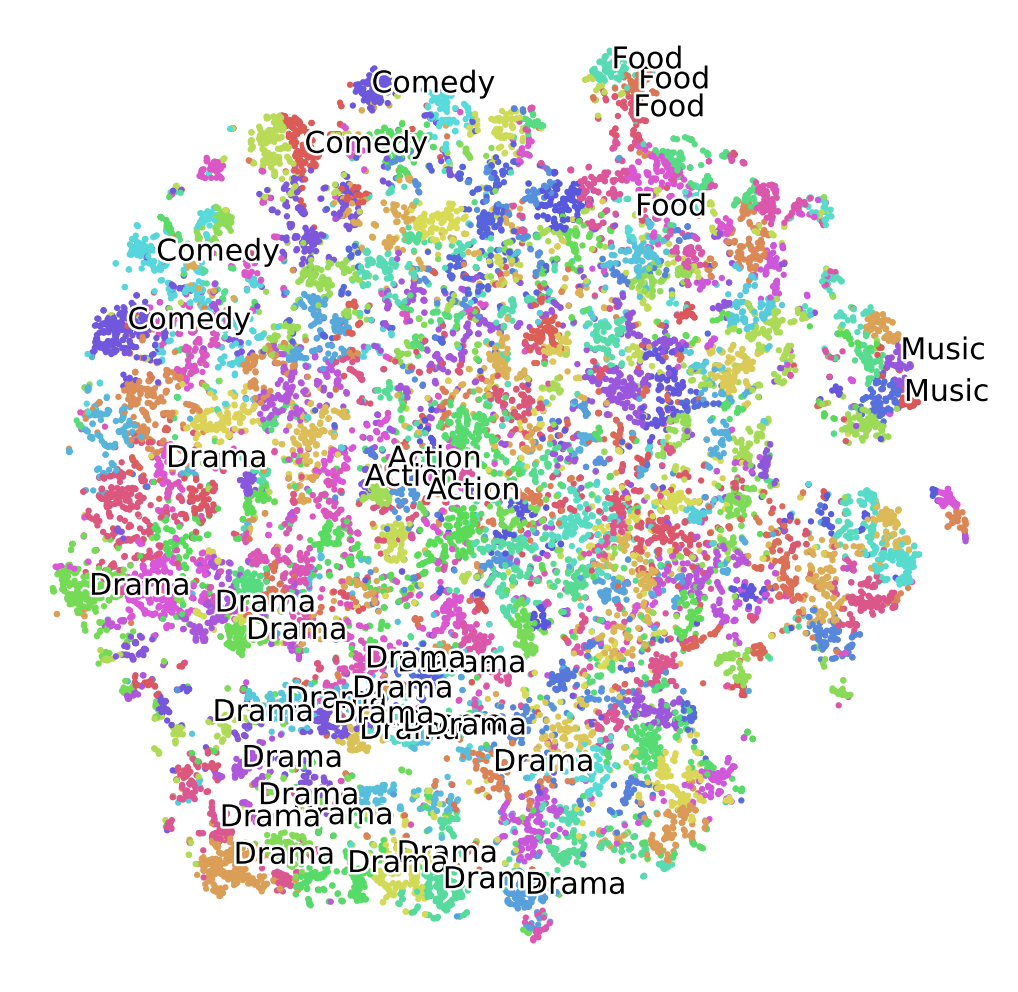

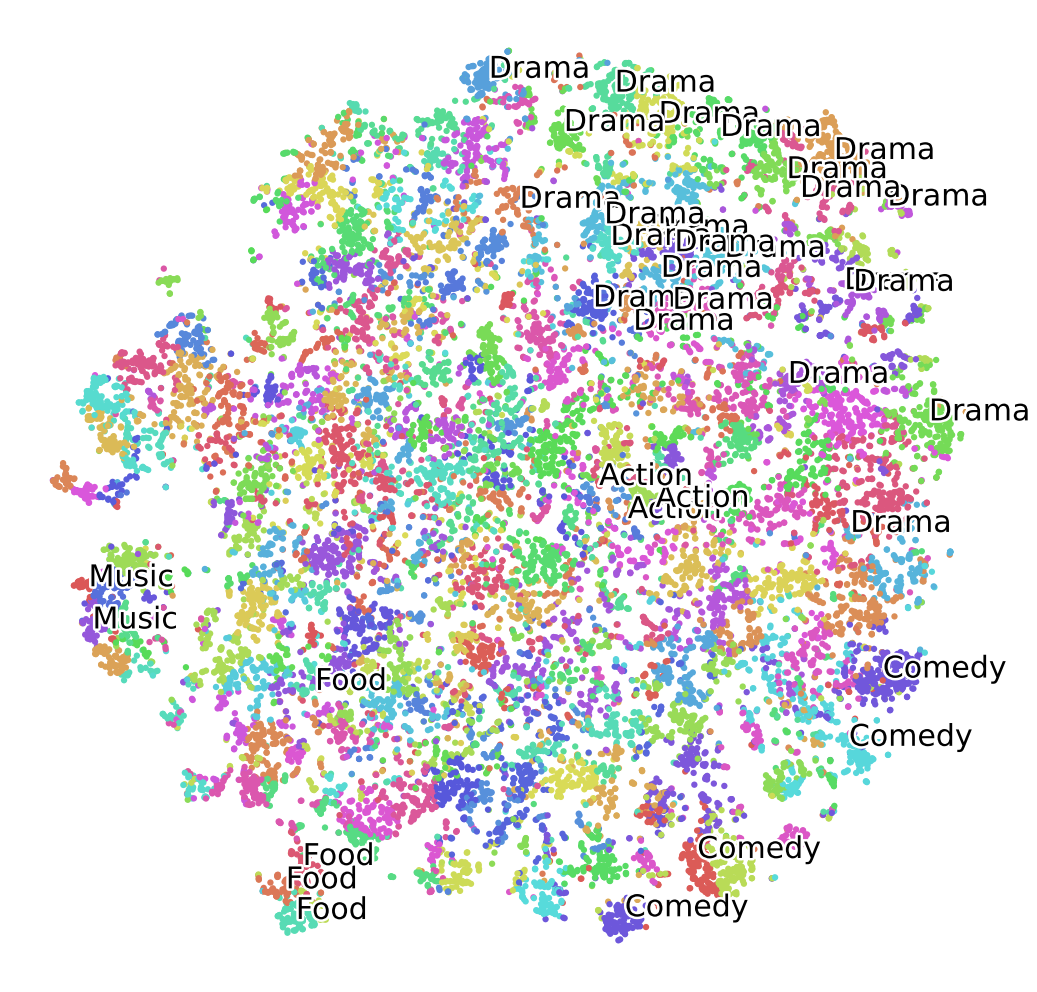

In [125]:
for p in tqdm.tqdm([5, 10, 15, 25, 45, 50]):
    res = TSNE(early_exaggeration=p).fit_transform(curr_feats)
    scatter(res, LabelEncoder().fit_transform(arc_feats['cluster']))
    plt.savefig('images/arcs_cluster_genre{0}.png'.format(p), dpi=120)